In [322]:
import numpy as np
import os
import itertools
import time
import torch
import math
from inspect import isfunction
from functools import partial

import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
# import tensorflow as tf

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import splev, splprep, interp1d
from scipy.integrate import cumtrapz

from scipy.signal import savgol_filter

def setdownflap(airfoil, theta=2, pose=0.65):
    lh_idx = np.argmin(airfoil[:,0])
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down = airfoil[lh_idx:,:]
    _i = np.abs(af_down[:,0] - pose).argmin()
    flap = af_down[_i:,:]
    flap = smooth_line(flap, flap.shape[0], 3)
    flap_new = flap - flap[0,:]
    flap_new = np.matmul(flap_new, R) + flap[0,:]
    af_down_new = np.copy(af_down)
    af_down_new[_i:,:] = np.copy(flap_new)
    theta = np.arctan2(af_down_new[-1,1] - af_down[-1,1], 1)
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down_new = np.matmul(af_down_new, R)
    af = np.zeros_like(airfoil)
    af[:lh_idx,:] = airfoil[:lh_idx,:]
    af[lh_idx:,:] = af_down_new
    return af

def setupflap(airfoil, theta=-2, pose=0.65):
    lh_idx = np.argmin(airfoil[:,0])
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_up = airfoil[:lh_idx,:]
    _i = np.abs(af_up[:,0] - pose).argmin()
    flap = af_up[:_i,:]
    flap = smooth_line(flap, flap.shape[0], 3)
    flap_new = flap - flap[-1,:]
    flap_new = np.matmul(flap_new, R) + flap[-1,:]
    af_up_new = np.copy(af_up)
    af_up_new[:_i,:] = np.copy(flap_new)
    theta = np.arctan2(af_up_new[0,1] - af_up[0,1], 1)
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_up_new = np.matmul(af_up_new, R)
    af = np.zeros_like(airfoil)
    af[lh_idx:,:] = airfoil[lh_idx:,:]
    af[:lh_idx,:] = af_up_new
    return af

def smooth_line(Q, N, k, D=20, resolution=1000):
    ''' Interpolate N points whose concentration is based on curvature. '''
    res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
    tck, u = res
    uu = np.linspace(u.min(), u.max(), resolution)
    x, y = splev(uu, tck, der=0)
    dx, dy = splev(uu, tck, der=1)
    ddx, ddy = splev(uu, tck, der=2)
    cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
    cv_int = cumtrapz(cv, uu, initial=0)
    fcv = interp1d(cv_int, uu)
    cv_int_samples = np.linspace(0, cv_int.max(), N)
    u_new = fcv(cv_int_samples)
    x_new, y_new = splev(u_new, tck, der=0)
    xy_new = np.vstack((x_new, y_new)).T
    return xy_new

def show_airfoil(af):
    fig, axs = plt.subplots(1, 1)
    axs.plot(af[:,0], af[:,1])
    axs.set_aspect('equal', 'box')
    fig.tight_layout()
    plt.show()

def derotate(airfoil):
    airfoil = Normalize(airfoil)
    ptail = 0.5 * (airfoil[0,:]+airfoil[-1,:])
    ptails = np.expand_dims(ptail, axis=0)
    ptails = np.repeat(ptails, airfoil.shape[0], axis=0)
    i = airfoil[:,0].argmin()
    phead = airfoil[i,:]
    theta = np.arctan2(-(airfoil[i,1] - ptail[1]), -(airfoil[i,0] - ptail[0]))
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    airfoil_R = airfoil
    airfoil_R -= np.repeat(np.expand_dims(phead, axis=0), airfoil_R.shape[0], axis=0)
    airfoil_R = np.matmul(airfoil_R, R)
    return airfoil_R

def Normalize(airfoil):
    airfoil[:,0] -= airfoil[:,0].min()
    r = np.maximum(airfoil[0,0], airfoil[-1,0])
    r = float(1.0/r)
    return airfoil * r

def interpolate(airfoil, points = 256, N = 3):
    a = 0.1
    b = 2
    af = np.copy(airfoil)
    lh_idx = np.argmin(af[:,0])
    lh_x = af[lh_idx, 0]
    th_x = np.minimum(af[0,0], af[-1,0])
    f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1], kind='linear')
    f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1], kind='linear')
    x = np.linspace(0,1,points//2)
    y = ((np.cos(np.pi + x * np.pi) + 1) / 2)
    # y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
    xx_down = y * (af[-1,0] - lh_x) + lh_x
    x = np.linspace(0,1,points//2+1)
    y = ((np.cos(np.pi + x * np.pi) + 1) / 2)
    # y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
    xx_up = y * (af[0,0] - lh_x) + lh_x
    yy_low = f_low(xx_down)
    yy_up = f_up(xx_up)
    aff = np.zeros([points,2])
    aff[:points//2,0] = np.flip(xx_up[1:])
    aff[:points//2,1] = np.flip(yy_up[1:])
    aff[points//2:,0] = xx_down
    aff[points//2:,1] = yy_low
    return aff


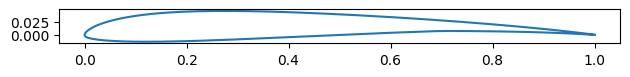

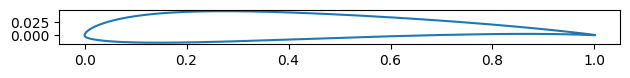

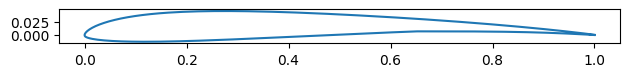

In [321]:
airfoil = np.loadtxt('BETTER/20150114-50 +2 d.dat', skiprows=1)
airfoil = interpolate(airfoil, 256, 3)
show_airfoil(airfoil)
af = np.copy(airfoil)
af = setdownflap(af, -2, 0.7)
show_airfoil(af)
af = setdownflap(af, theta=2, pose=0.65)
af = interpolate(af, 256, 3)
show_airfoil(af)
np.savetxt('tmp/airfoil.dat', af)

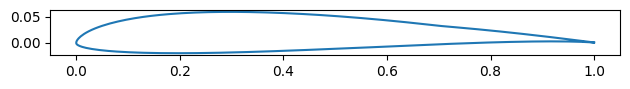

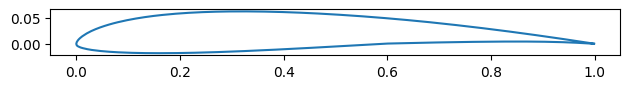

In [234]:
from airfoil_process import *
airfoil = np.loadtxt('SynerJ/SynerJ-100.dat', skiprows=1)
airfoil = derotate(airfoil)
airfoil_i = np.copy(airfoil)
airfoil_i = derotate(airfoil_i)
airfoil_i = interpolate(airfoil_i, 256, 3)
show_airfoil(airfoil)
af = setupflap(airfoil_i, theta=2, pose=0.7)
af = setdownflap(af, theta=2, pose=0.6)
af = interpolate(af, 256, 3)
show_airfoil(af)
np.savetxt('tmp/airfoil.dat', af)

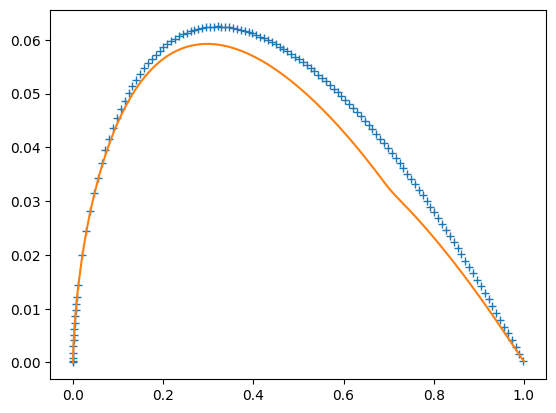

In [235]:
lh_idx = np.argmin(af[:,0])
lh_x = af[lh_idx, 0]
# Get trailing head
th_x = np.minimum(af[0,0], af[-1,0])
# Interpolate
f_up = interp1d(af[:lh_idx+1,0], af[:lh_idx+1,1])
f_low = interp1d(af[lh_idx:,0], af[lh_idx:,1])
points = 256
a = 0.1
b = 2
x = np.linspace(0,1,points//2)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_down = y * (af[-1,0] - lh_x) + lh_x
x = np.linspace(0,1,points//2+1)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_up = y * (af[0,0] - lh_x) + lh_x
yy_up = f_up(xx_up)
yy_low = f_low(xx_down)
plt.plot(xx_up[:],yy_up[:], '+')
# plt.plot(xx_down[:],yy_low[:], '+')

lh_idx = np.argmin(airfoil[:,0])
lh_x = airfoil[lh_idx, 0]
# Get trailing head
th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
# Interpolate
f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
points = 256
a = 0.1
b = 2
x = np.linspace(0,1,points//2)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_down = y * (airfoil[-1,0] - lh_x) + lh_x
x = np.linspace(0,1,points//2+1)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_up = y * (airfoil[0,0] - lh_x) + lh_x
yy_up = f_up(xx_up)
yy_low = f_low(xx_down)
plt.plot(xx_up[:],yy_up[:], '')
# plt.plot(xx_down[:],yy_low[:], '')
# plt.plot(airfoil[lh_idx:,0],airfoil[lh_idx:,1], '+')

In [236]:
v = 10
d = 0.3
span = 2.5
area = d * span
density = 1.225
vis = 1.5 * 10 ** (-5)
reynolds = v * density * d / vis
mass = 6
g = 9.806
cl = mass * g / (0.5 * area * density * (v ** 2))
reynolds, cl

(244999.99999999994, 1.2807836734693878)

In [237]:
from utils_win import *
cl, cd = compute_coeff(af, reynolds, 0, cl)
perf = cl / cd
perf

name 'pexpect' is not defined
XFoil error!


nan

In [238]:
def type2_resqrtcl(mass, diameter, area):
    g = 9.806
    viscosity = 1.5e-5
    re_sqrtcl = np.sqrt(2 * mass * g / density / area) * diameter / viscosity
    return re_sqrtcl

def compute_t2_coeff(airfoil, re_sqrtcl=50000, alpha_min=0, alpha_max = 5, alpha_step = 0.5, n_iter=2000, tmp_dir='tmp'):
    create_dir(tmp_dir)
    gc.collect()
    safe_remove('{}/airfoil.log'.format(tmp_dir))
    fname = '{}/airfoil.dat'.format(tmp_dir)
    with open(fname, 'wb') as f:
        np.savetxt(f, airfoil)
    try:
        if platform.system().lower() == 'windows':
            child = wexpect.spawn('xfoil')
        else:
            child = pexpect.spawn('xfoil')
        timeout = 10
        
        child.expect('XFOIL   c> ', timeout)
        child.sendline('load {}/airfoil.dat'.format(tmp_dir))
        child.expect('Enter airfoil name   s> ', timeout)
        child.sendline('af')
        child.expect('XFOIL   c> ', timeout)
        child.sendline('OPER')
        child.expect('.OPERi   c> ', timeout)
        child.sendline('t2')
        child.expect('.OPERi   c> ', timeout)
        child.sendline('VISC {}'.format(re_sqrtcl))
        child.expect('.OPERv   c> ', timeout)
        child.sendline('ITER {}'.format(n_iter))
        child.expect('.OPERv   c> ', timeout)
        child.sendline('PACC')
        child.expect('Enter  polar save filename  OR  <return> for no file   s> ', timeout)
        child.sendline('{}/airfoil.log'.format(tmp_dir))
        child.expect('Enter  polar dump filename  OR  <return> for no file   s> ', timeout)
        child.sendline()
        child.expect('.OPERva   c> ', timeout)
        child.sendline('aseq {} {} {}'.format(alpha_min, alpha_max, alpha_step))
        child.expect('c> ', timeout)
        child.sendline()
        child.expect('XFOIL   c> ', timeout)
        child.sendline('quit')
        
        child.close()
    
        res = np.loadtxt('{}/airfoil.log'.format(tmp_dir), skiprows=12)
        CL = res[:,1]
        CD = res[:,2]
            
    except Exception as ex:
        # print(ex)
        print('XFoil error!')
        CL = np.nan
        CD = np.nan
        
    safe_remove(':00.bl')
    
    return CL, CD

def gliding_perf(af, mass, d, span, alpha_min=0, alpha_max = 5, alpha_step = 0.5):
    area = d * span
    re_sqrtcl = type2_resqrtcl(mass, d, area)
    cl, cd = compute_t2_coeff(af, re_sqrtcl, alpha_min, alpha_max, alpha_step)
    perf = cl/cd
    vz = np.sqrt((cl ** 3) / (cd ** 2))
    try:
        i = perf.argmax()
        perf = perf.max()
        return perf, cl[i], cd[i], vz.max()
    except:
        return perf, cl, cd, vz


In [239]:
mass = 0.32
g = 9.806
d = 0.145
span = 1.5
area = d * span
viscosity = 1.5e-5

re_sqrtcl = type2_resqrtcl(mass, d, area)

perf, cl, cd, vz = gliding_perf(af, mass, d, span)
perf, cl, cd, vz

XFoil error!


(nan, nan, nan, nan)

In [350]:
import xlsxwriter

def rotate_af(airfoil, pose, theta, resol = 1000):
    af = np.copy(airfoil)
    af = interpolate(af, resol)
    idx_head = af[:,0].argmin()
    a = abs(af[idx_head:,0]-pose)
    _i = a.argmin() + idx_head
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_new = af - af[_i,:]
    af_new = np.matmul(af_new, R) + af[_i,:]
    af_new = interpolate(af_new, 256)
    return af_new

def range_af(airfoil, d):
    af = np.copy(airfoil)
    af *= d
    return af

def expand_z(airfoil, z):
    af = np.copy(airfoil)
    tmp = np.ones([af.shape[0],1])
    tmp *= z
    af = np.concatenate([af,tmp], axis=1)
    return af

def writetoxls(airfoil, path = 'demo.xlsx', row = 0, end = False):
    workbook = xlsxwriter.Workbook(path)
    worksheet = workbook.add_worksheet()
    worksheet.write(row, 0, "StartLoft")
    row += 1
    worksheet.write(row, 0, "StartCurve")
    row += 1
    for i in range(af.shape[0]):
        worksheet.write(row, 1, airfoil[i,0])
        worksheet.write(row, 2, airfoil[i,1])
        worksheet.write(row, 0, airfoil[i,2])
        row += 1

    worksheet.write(row, 0, "EndCurve")
    row += 1
    worksheet.write(row, 0, "EndLoft")
    row += 1
    if end:
        worksheet.write(row, 0, "End")
        row += 1
    workbook.close()
    return row

def writetxt(airfoil, mode = 'a', path = 'demo.txt', end = False):
    f = open(path, mode)
    f.write("StartLoft\n")
    f.write("StartCurve\n")
    for i in range(airfoil.shape[0]):
        f.write(f'{airfoil[i,2]}, {airfoil[i,0]}, {airfoil[i,1]}\n')

    f.write("EndCurve\n")
    f.write("EndLoft\n")
    if end:
        f.write("End\n")
    f.close()

def txt2xlsx(txtpath = 'demo.txt', xlsxpath = 'demo.xlsx'):
    f = open(txtpath,'r')
    row = 0
    path = xlsxpath
    workbook = xlsxwriter.Workbook(path)
    worksheet = workbook.add_worksheet()
    seg = re.compile(', ')
    for line in f:
        line = line.split('\n')[0]
        if seg.search(line) is not None:
            worksheet.write(row, 0, float(line.split(', ')[0]))
            worksheet.write(row, 1, float(line.split(', ')[1]))
            worksheet.write(row, 2, float(line.split(', ')[2]))
            row += 1
        else:
            worksheet.write(row, 0, line.split('\n')[0])
            row += 1
    workbook.close()

def cal_offset(x, y, root, flappose, angle, offset = 0):
    rootflap = root * flappose
    x_flap = rootflap + np.tan(angle) * y
    d = x_flap - x * (flappose - offset)
    return d

def writeairfoil(aff, flappose, span, diameter, alpha = 5.5, twist = 0, root=180, offset = 0, angle = 0, mode = 'a', end = False):
    aff = derotate(aff)
    if offset != 0:
        afftip = np.copy(aff)
        afftip = setdownflap(afftip, theta=-2, pose=flappose)
        aff = setdownflap(afftip, theta=2, pose=flappose-offset)
    aff = rotate_af(aff, flappose-offset, twist)
    aff = range_af(aff, diameter)
    x_offset = cal_offset(diameter, span, root, flappose, angle, offset)
    y_offset = span * np.tan(alpha * np.pi / 180)
    aff += np.array([x_offset, y_offset])
    aff = expand_z(aff, span)
    writetxt(aff, mode, end=end)
    return x_offset, x_offset + diameter

aff = rotate_af(af, 0.6, -2)
aff = range_af(af, 150)
x_offset = 10
y_offset = 500 * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, 500)

In [324]:
root = 180
tip = 0.2
span = 7.5
angle = 0.0
flappose = 0.65

def cal_offset(x, y, root, flappose, angle, offset = 0):
    rootflap = root * flappose
    x_flap = rootflap + np.tan(angle) * y
    d = x_flap - x * (flappose - offset)
    return d

offsets = {}
n = 0
for i in np.linspace(20, 180, 17):
    offsets[f'{i:.1f}'] = cal_offset(i, 4, root, flappose, angle)
    n += 1

offsets
cal_offset(30, 750, root, flappose, angle, offset=1.5)

142.5

In [351]:
import re
import os
dat = re.compile('.dat')
# dat = re.compile('airfoil.*\.dat')
root = 'synergy2/'

airfoils = {}
for path, dir, files in os.walk(root):
    for file in files:
        if dat.search(file) is not None:
            airfoils['{}{}'.format(path,file)] = file.split(' +')[0]

files.sort()
afs = {}
for file in airfoils.keys():
    points = file
    name = airfoils[file]
    print(points, name)
    airfoil = np.loadtxt(points, skiprows=1)
    # af = interpolate(airfoil, 256, 3)
    af = setdownflap(airfoil, -2, 0.7)
    af = setdownflap(af, theta=2, pose=0.65)
    # af = interpolate(airfoil, 256, 3)
    afs[name] = af

synergy2/20100901-5f tip +2.dat 20100901-5f tip
synergy2/20120105-25-20 +2.dat 20120105-25-20
synergy2/20120105-50T85 +2.dat 20120105-50T85
synergy2/20120105-60T85 +2.dat 20120105-60T85
synergy2/20140417-30 +2.dat 20140417-30
synergy2/20140417-35 +2.dat 20140417-35
synergy2/20140417-40 +2.dat 20140417-40
synergy2/20140417-45 +2.dat 20140417-45
synergy2/20140417-47.5 +2.dat 20140417-47.5
synergy2/20140417-49 +2.dat 20140417-49
synergy2/20140417-50 +2.dat 20140417-50
synergy2/20140424-35 +2.dat 20140424-35
synergy2/20140430-20 +2.dat 20140430-20
synergy2/20140501-20 +2.dat 20140501-20
synergy2/20140501b-20 +2.dat 20140501b-20
synergy2/20140504-35 +2.dat 20140504-35
synergy2/20140520-40 +2.dat 20140520-40
synergy2/424-35+430-20 +2.dat 424-35+430-20


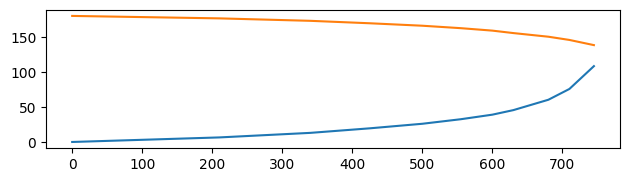

In [388]:
x1s = []
x2s = []
x = [0, 210, 340, 425, 500, 555, 600, 630, 680, 710, 745]
aff = np.copy(afs['20120105-60T85'])
x1,x2 = writeairfoil(aff, 0.65, x[0], 180, twist=0, root=180, mode='w')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-49'])
x1,x2 = writeairfoil(aff, 0.65, x[1], 170, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-47.5'])
x1,x2 = writeairfoil(aff, 0.65, x[2], 160, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-45'])
x1,x2 = writeairfoil(aff, 0.65, x[3], 150, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-40'])
x1,x2 = writeairfoil(aff, 0.65, x[4], 140, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-35'])
x1,x2 = writeairfoil(aff, 0.65, x[5], 130, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20140417-30'])
x1,x2 = writeairfoil(aff, 0.65, x[6], 120, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20120105-25-20'])
x1,x2 = writeairfoil(aff, 0.65, x[7], 110, twist=0, root=180, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20100901-5f tip'])
x1,x2 = writeairfoil(aff, 0.65, x[8], 90, twist=0, root=180, offset=0.02, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20100901-5f tip'])
x1,x2 = writeairfoil(aff, 0.65, x[9], 70, twist=0, root=180, offset=0.06, mode='a')
x1s.append(x1)
x2s.append(x2)
aff = np.copy(afs['20100901-5f tip'])
x1,x2 = writeairfoil(aff, 0.65, x[10], 30, twist=0, root=180, offset=0.36, mode='a', end=True)
x1s.append(x1)
x2s.append(x2)
fig, axs = plt.subplots(1, 1)
axs.plot(x,x1s)
axs.plot(x,x2s)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()
txt2xlsx()

In [244]:
aff = np.copy(afs['20140417-49'])
span = 200
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.1)
aff = range_af(af, 170)
x_offset = offsets['1.7'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [245]:
aff = np.copy(afs['20140417-49'])
span = 340
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.15)
aff = range_af(af, 160)
x_offset = offsets['1.6'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [246]:
aff = np.copy(afs['20140417-47.5'])
span = 420
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.2)
aff = range_af(af, 150)
x_offset = offsets['1.5'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [247]:
aff = np.copy(afs['20140417-45'])
span = 500
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.25)
aff = range_af(af, 140)
x_offset = offsets['1.4'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [248]:
aff = np.copy(afs['20140417-40'])
span = 570
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.3)
aff = range_af(af, 130)
x_offset = offsets['1.3'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [249]:
aff = np.copy(afs['20140417-35'])
span = 600
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.4)
aff = range_af(af, 120)
x_offset = offsets['1.2'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)

In [250]:
aff = np.copy(afs['20140417-30'])
span = 660
aff = derotate(aff)
aff = rotate_af(af, 0.6, -0.5)
aff = range_af(af, 110)
x_offset = offsets['1.1'] * 100
y_offset = span * np.tan(5.5 * np.pi / 180)
aff += np.array([x_offset, y_offset])
aff = expand_z(aff, span)
writetxt(aff)